### Imports and Configuration

This cell sets up the environment by importing necessary libraries and defining key parameters for the object detection process.

*   **Imports**: Libraries such as `onnxruntime` (for model execution), `cv2` (OpenCV for image processing and NMS), `numpy` (for array operations), `PIL` (for visualization), and `matplotlib` (for displaying the image) are loaded.
*   **Configuration**:
    *   **`ONNX_MODEL_PATH`**: Path to the ONNX model file. In this context, the model is identified as a likely **YOLOv11m** or similar architecture.
        *   **Input**: The model expects a normalized image tensor of shape $\mathbf{(1, 3, 640, 640)}$ (Batch, Channels, Height, Width).
        *   **Output**: The model outputs a tensor typically containing all prediction candidates, with shape $\mathbf{(1, N, 5 + C)}$ (where $N$ is the number of boxes, $5$ is $\text{center } x, \text{center } y, w, h, \text{score}$, and $C$ is class count).
    *   **`SAMPLE_IMAGE_PATH`**: The input image file path.
    *   **`CONF_THRESHOLD`**: Minimum confidence score for a detection.
    *   **`NMS_THRESHOLD`**: Intersection over Union (IoU) threshold for Non-Maximum Suppression.
    *   **`CLASS_NAMES`**: A list of detectable classes, containing only "ship".

In [5]:
import onnxruntime as ort
import numpy as np
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt

# --- 1. Configuration ---
ONNX_MODEL_PATH = "./ship_detection.onnx"  # path to your ONNX model
SAMPLE_IMAGE_PATH = "./images/ship/P0001_3000_3800_7200_8000_png.rf.345ea817b061262774162c6305532763.jpg"  # path to a single image
CONF_THRESHOLD = 0.6
NMS_THRESHOLD = 0.45
CLASS_NAMES = ["ship"]


### Helper Functions

This cell defines two essential functions for the inference pipeline:

1.  **`preprocess_image`**: This function prepares the input image for the model.
    *   It reads the image and calculates the necessary scaling factor to resize the image while maintaining its aspect ratio.
    *   It then **pads** the resized image onto a square canvas (e.g., $640 \times 640$) filled with a grey color (pixel value 114, a common practice in YOLO models).
    *   Finally, it normalizes the pixels to $0.0-1.0$, transposes the dimensions to $\mathbf{(C, H, W)}$, and adds a batch dimension $\mathbf{(1, C, H, W)}$, which is the required ONNX input format. It returns the input tensor, original image size, scale factor, and padding amounts.

2.  **`postprocess_output`**: This function interprets the raw model output tensor.
    *   It filters the predictions based on the confidence threshold (`conf_thresh`).
    *   It converts the bounding box coordinates from the YOLO format ($\text{center } x, \text{center } y, w, h$) to the corner format ($\text{xmin}, \text{ymin}, \text{xmax}, \text{ymax}$).
    *   It applies **Non-Maximum Suppression (NMS)** using `cv2.dnn.NMSBoxes` to remove redundant, overlapping detections.
    *   It then **rescales** the surviving bounding box coordinates back to the original image's dimensions, compensating for both the initial scaling and padding.

In [6]:
# --- 2. Helper functions ---


def preprocess_image(img_path, target_size=640):
    """Resize image and pad to target_size for ONNX input."""
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    h_orig, w_orig, _ = img.shape
    scale = min(target_size / h_orig, target_size / w_orig)
    w_new, h_new = int(w_orig * scale), int(h_orig * scale)
    img_resized = cv2.resize(img, (w_new, h_new))
    canvas = np.full((target_size, target_size, 3), 114, dtype=np.uint8)
    top_pad, left_pad = (target_size - h_new) // 2, (target_size - w_new) // 2
    canvas[top_pad : top_pad + h_new, left_pad : left_pad + w_new] = img_resized
    input_tensor = (canvas.astype(np.float32) / 255.0).transpose(2, 0, 1)
    input_tensor = np.expand_dims(input_tensor, axis=0)
    return input_tensor, (h_orig, w_orig), scale, (top_pad, left_pad)


def postprocess_output(
    output, orig_shape, scale, padding, conf_thresh=0.25, nms_thresh=0.45
):
    """Apply confidence threshold and NMS, convert boxes back to original image coordinates."""
    preds = np.squeeze(output).T
    scores = preds[:, 4]
    preds = preds[scores > conf_thresh]
    if len(preds) == 0:
        return [], []
    scores = scores[scores > conf_thresh]
    boxes_raw = preds[:, :4]
    # Convert from center x,y,w,h to x_min, y_min, x_max, y_max
    boxes_xywh = np.copy(boxes_raw)
    boxes_xywh[:, 0] = boxes_raw[:, 0] - boxes_raw[:, 2] / 2
    boxes_xywh[:, 1] = boxes_raw[:, 1] - boxes_raw[:, 3] / 2
    boxes_xywh[:, 2] = boxes_raw[:, 0] + boxes_raw[:, 2] / 2
    boxes_xywh[:, 3] = boxes_raw[:, 1] + boxes_raw[:, 3] / 2
    # Apply NMS
    indices = cv2.dnn.NMSBoxes(
        boxes_xywh.tolist(), scores.tolist(), conf_thresh, nms_thresh
    )
    if len(indices) == 0:
        return [], []
    indices = indices.flatten()
    final_boxes = boxes_xywh[indices]
    final_scores = scores[indices]
    h_orig, w_orig = orig_shape
    top_pad, left_pad = padding
    final_boxes[:, 0] = (final_boxes[:, 0] - left_pad) / scale
    final_boxes[:, 1] = (final_boxes[:, 1] - top_pad) / scale
    final_boxes[:, 2] = (final_boxes[:, 2] - left_pad) / scale
    final_boxes[:, 3] = (final_boxes[:, 3] - top_pad) / scale
    final_boxes = np.clip(final_boxes, [0, 0, 0, 0], [w_orig, h_orig, w_orig, h_orig])
    return final_boxes.astype(int), final_scores


### Model Loading and Inference Execution

This cell performs the crucial steps of loading the ONNX model, preparing the input, and executing the forward pass, with diagnostics printed to the console.

1.  **Model Loading (Section 3)**:
    *   The `ort.InferenceSession` is initialized, preparing the model for execution.
    *   **Input Key/Shape**: The input tensor is named **`images`** and has a static shape of **`[1, 3, 640, 640]`**. This confirms the model expects a single $640 \times 640$ image with 3 color channels.
    *   **Output Key/Shape**: The single output tensor is named **`output0`** and has a static shape of **`[1, 5, 8400]`**. This is a specific YOLO format (likely exported with $\text{confidence}$ and $\text{class scores}$ combined).
        *   $1$: Batch size.
        *   $5$: Features per bounding box ($\text{center } x, \text{center } y, w, h, \text{combined score}$). *Note: This $\mathbf{5}$ implies the single class score is often merged with objectness, common in simplified single-class exports.*
        *   $8400$: Total number of prediction candidates (anchors/boxes) on the grid.

2.  **Image Pre-processing (Section 4)**:
    *   The `preprocess_image` function creates the input tensor.
    *   **Actual Input Shape**: The tensor confirms the shape **`(1, 3, 640, 640)`** matches the model's static input shape.
    *   **Original Shape**: The original image is $640 \times 640$, which in this case means no scaling or padding was applied, simplifying the transformations.

3.  **Inference (Section 5)**:
    *   `ort_session.run()` executes the model.
    *   **Actual Output Shape**: The raw prediction tensor confirms the final output shape is **`(1, 5, 8400)`**. This tensor is the input for the next post-processing step, where the $8400$ candidates will be filtered by score and NMS.

In [7]:
# --- 3. Load ONNX model ---
ort_session = ort.InferenceSession(ONNX_MODEL_PATH)
input_info = ort_session.get_inputs()[0]
output_info = ort_session.get_outputs()[0]
input_name = input_info.name
output_name = output_info.name
input_shape = input_info.shape
output_shape_static = output_info.shape

print(f"Model Input Name: {input_name}")
print(f"Static Input Shape: {input_shape}")
print(f"Model Output Name: {output_name}")
print(f"Static Output Shape: {output_shape_static}")
print("-" * 30)

# --- 4. Preprocess image ---
input_tensor, orig_shape, scale, padding = preprocess_image(SAMPLE_IMAGE_PATH)
print(f"Preprocessed Input Tensor Shape (Actual): {input_tensor.shape}")
print(f"Original Image Shape (H, W): {orig_shape}")
print("-" * 30)

# --- 5. Run inference ---
outputs = ort_session.run([output_name], {input_name: input_tensor})
output_tensor = outputs[0]
print(f"Inference Complete. Raw Output Tensor Shape (Actual): {output_tensor.shape}")


Model Input Name: images
Static Input Shape: [1, 3, 640, 640]
Model Output Name: output0
Static Output Shape: [1, 5, 8400]
------------------------------
Preprocessed Input Tensor Shape (Actual): (1, 3, 640, 640)
Original Image Shape (H, W): (640, 640)
------------------------------
Inference Complete. Raw Output Tensor Shape (Actual): (1, 5, 8400)


### Post-processing and Visualization

This cell executes the final steps to present the detection results:

1.  **Post-processing**: The `postprocess_output` function is called, passing the raw predictions and the necessary geometric parameters (original shape, scale, padding) from the pre-processing step. This function performs confidence filtering, NMS, and scaling, returning the final bounding boxes (`pred_boxes`) and their confidence scores (`pred_scores`).
2.  **Visualization**:
    *   The original image is re-loaded using `PIL.Image`.
    *   It then iterates through the final detections. For each detected box, it uses `PIL.ImageDraw` to draw a red rectangle and a label (class name and score) onto the image.
3.  **Display**: The final image with the drawn detections is displayed using `matplotlib.pyplot`.

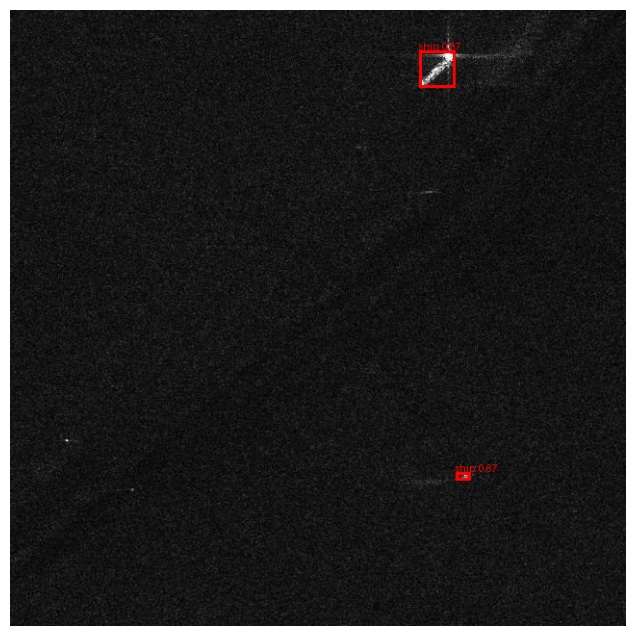

In [8]:
# --- 6. Postprocess (NMS + rescale) ---
pred_boxes, pred_scores = postprocess_output(
    outputs[0],
    orig_shape,
    scale,
    padding,
    conf_thresh=CONF_THRESHOLD,
    nms_thresh=NMS_THRESHOLD,
)

# --- 7. Visualization ---
image = Image.open(SAMPLE_IMAGE_PATH).convert("RGB")
draw = ImageDraw.Draw(image)
for box, score in zip(pred_boxes, pred_scores):
    xmin, ymin, xmax, ymax = box
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
    draw.text((xmin, ymin - 10), f"{CLASS_NAMES[0]}: {score:.2f}", fill="red")

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()